# Testing the package "fem_toolbox" for 2D frame structures

---

**This notebook makes ideal use of the package and all its functionality for a 2D frame structure, bringing the user through the ideal FEA workflow. It can therefore be seen as a tutorial and used as reference for other cases.**

---

In [1]:
import fem_toolbox as ft

  __                _              _ _               
 / _|              | |            | | |              
| |_ ___ _ __ ___  | |_ ___   ___ | | |__   _____  __
|  _/ _ \ '_ ` _ \ | __/ _ \ / _ \| | '_ \ / _ \ \/ /
| ||  __/ | | | | || || (_) | (_) | | |_) | (_) >  < 
|_| \___|_| |_| |_| \__\___/ \___/|_|_.__/ \___/_/\_\
                ______                               
               |______|                              

github.com/Gabbbri/fem_toolbox


## Preprocessing

In [2]:
# reading geometry
nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../Tutorials/geometry&boundary-files/myframe.txt")

In [3]:
# meshing
elements_per_beam = 5

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

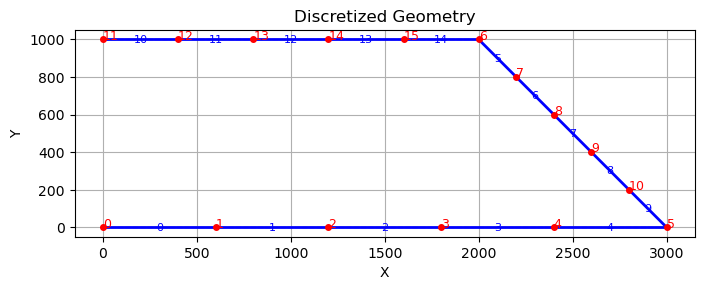

In [4]:
# geometry and mesh visualization
ft.mesh.plot_discretized_geometry_2D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

In [5]:
# read BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../Tutorials/geometry&boundary-files/2D_bc_forces.txt")

# define element type (frame element (2d beam)-> ndofs_per_element = 3)
ndofs_per_node = 3

# validate constraints
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndofs_per_node, bc_nodes, bc_dofs)


Constraint check passed: 6 DOFs constrained out of 48.


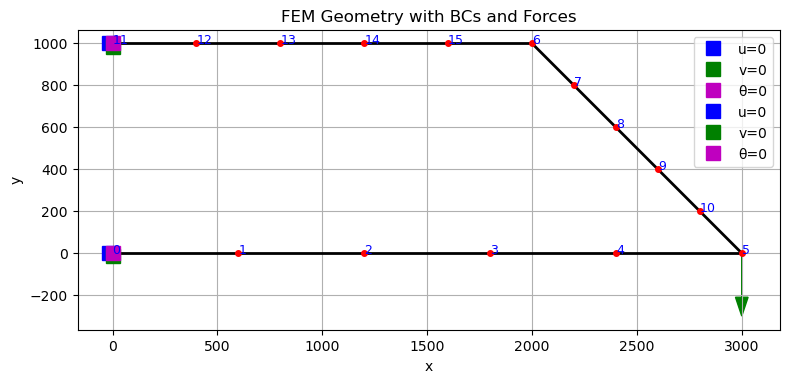

In [6]:
# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.3)

## FEA

In [7]:
# assemble global matrices
K_frame = ft.femsolver.assembleK(ft.elements.k_beam2d, ft.elements.rotation_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=3)

M_frame = ft.femsolver.assembleM(ft.elements.m_beam2d, ft.elements.rotation_2d, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node=3)

In [8]:
# build global force vector
num_dofs = K_frame.shape[0]
dofs_per_node = 3   # 2d beam element
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, dofs_per_node)

In [9]:
# static analysis
u = ft.femsolver.static_analysis(K_frame, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node=3)

# modal analysis
frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_frame, M_frame, bc_nodes, bc_dofs, ndof_per_node=3, verbose=False)


## Post-processing

In [10]:
# stress computation
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_beam2d, ft.elements.rotation_2d, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=ndofs_per_node)

# reaction components
reactions, _ = ft.postprocessing.compute_reaction_forces(K_frame, u, bc_nodes, bc_dofs, ndofs_per_node)


DOF 0: Reaction force = 1747.25 N
DOF 1: Reaction force = 276.00 N
DOF 2: Reaction force = 428260.64 N
DOF 33: Reaction force = -1747.25 N
DOF 34: Reaction force = 724.00 N
DOF 35: Reaction force = 824493.69 N


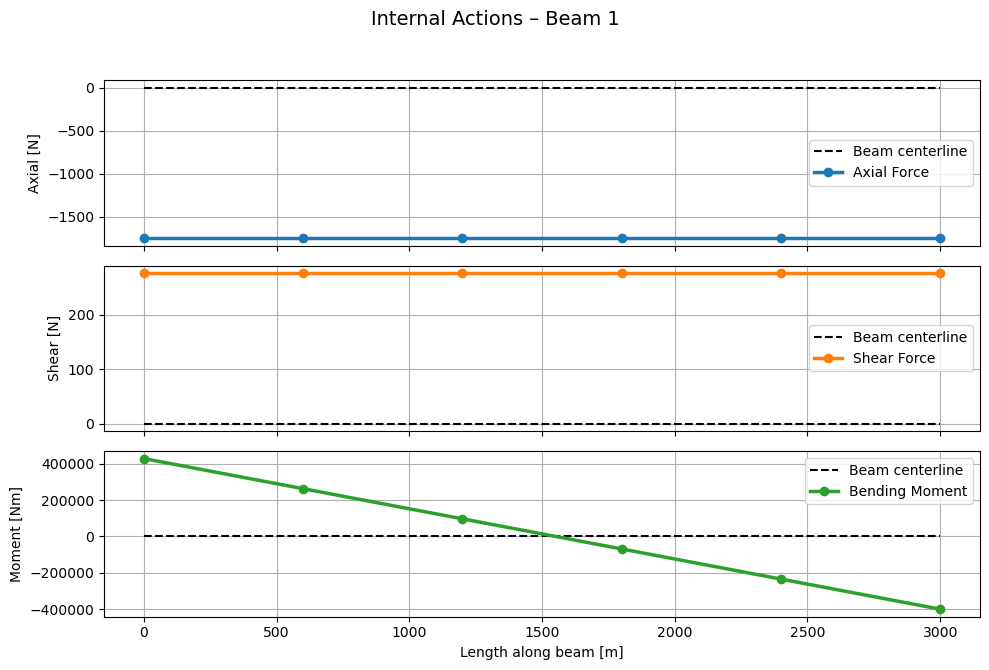

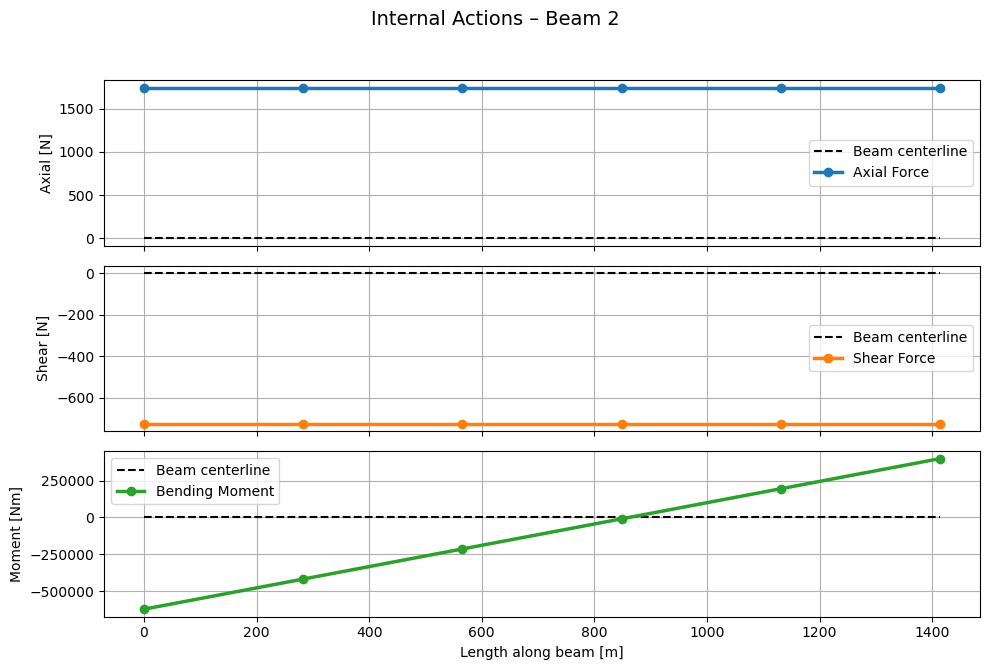

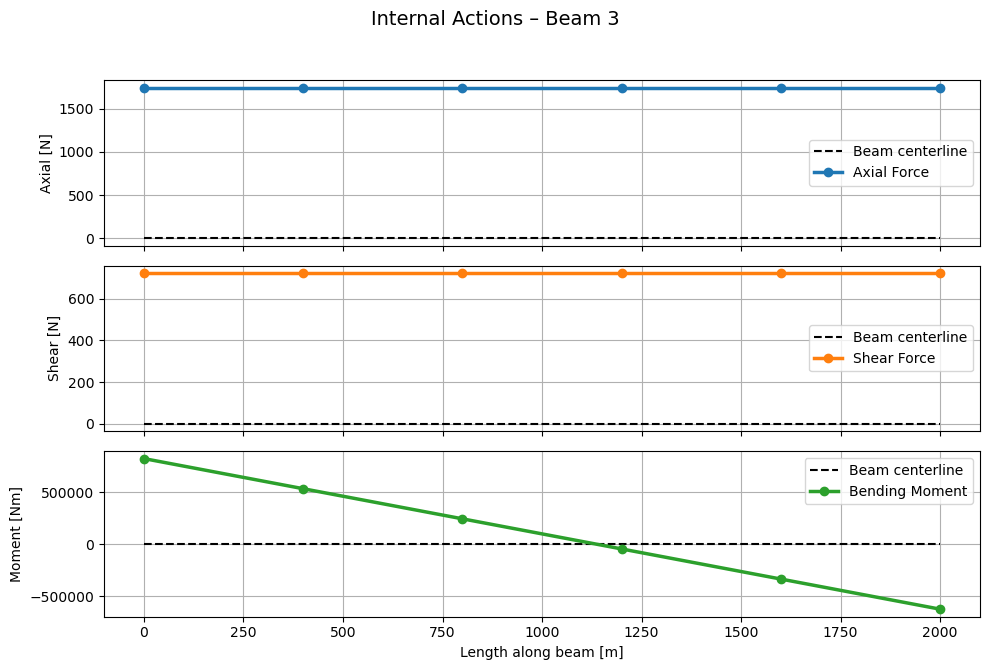

In [11]:
# plotting internal actions in the beams
ft.postprocessing.plot_internal_actions_2D(beam_connectivity, fem_nodes, fem_elements, internal_actions, elements_per_beam=5)

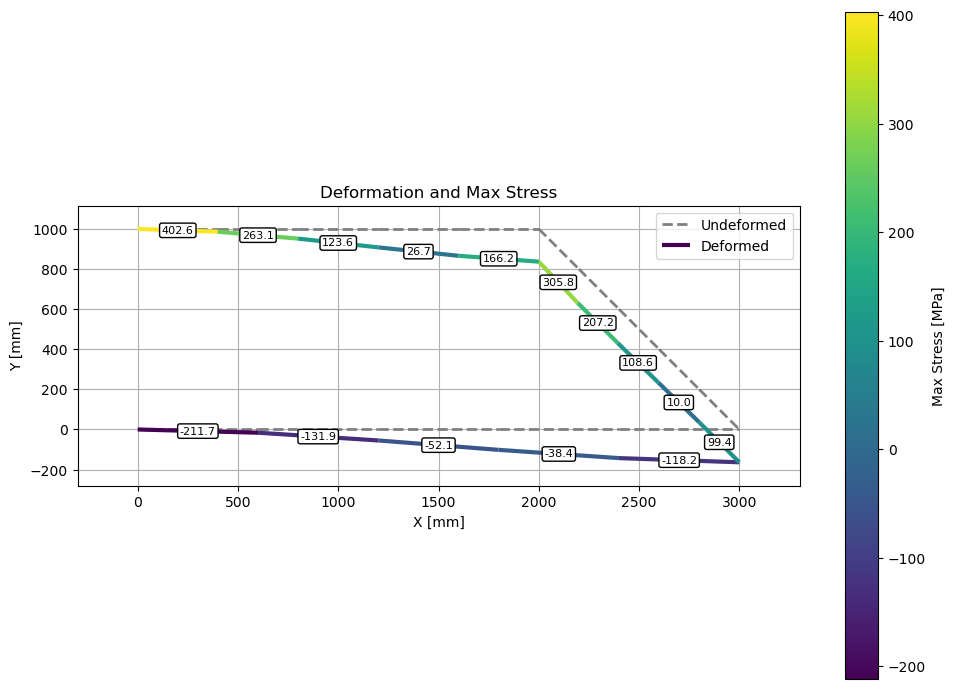

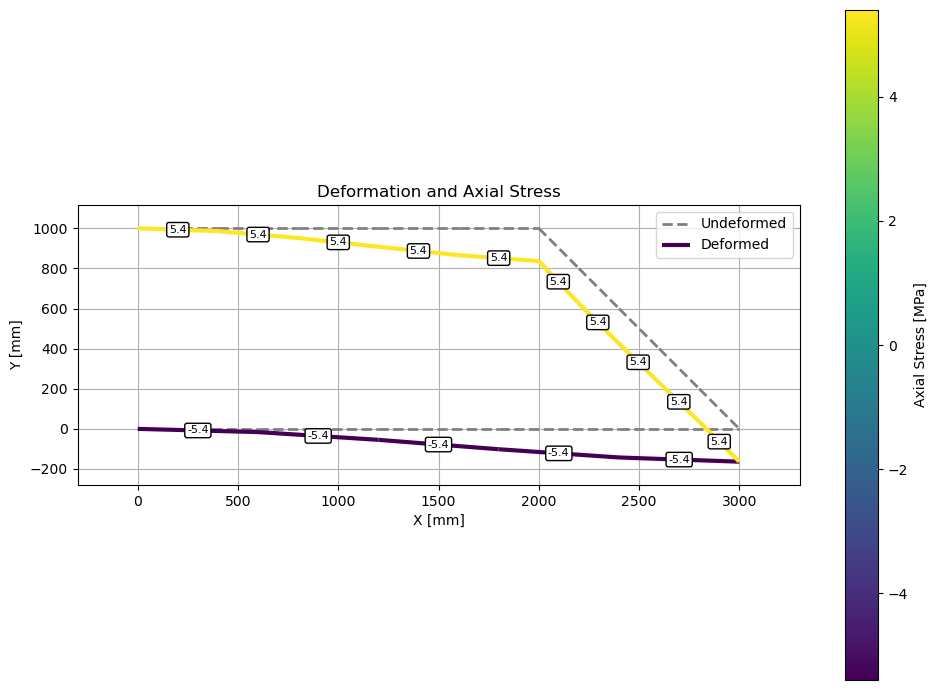

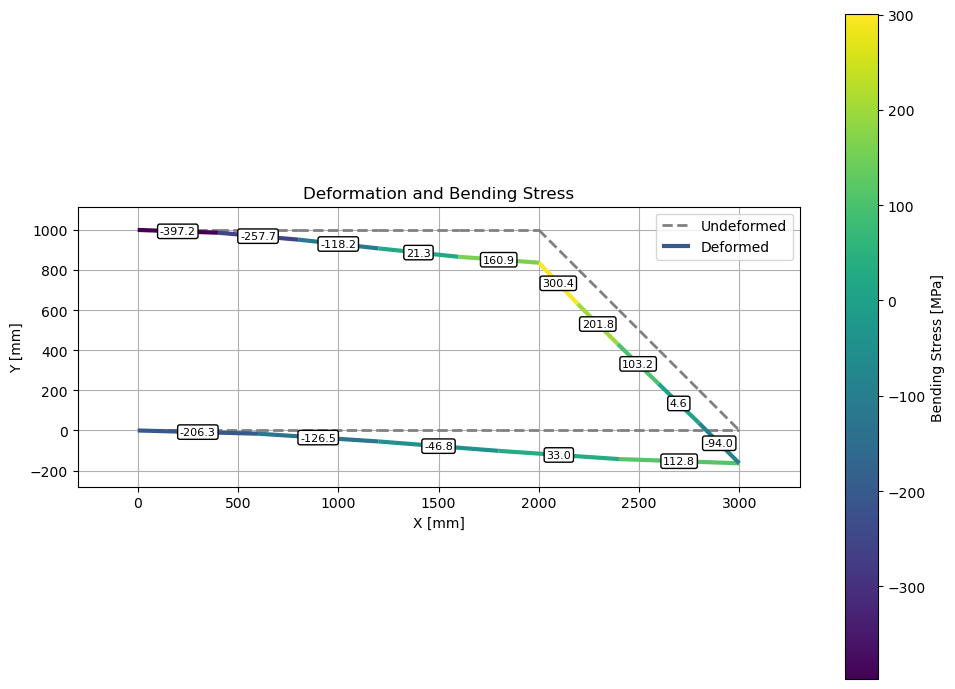

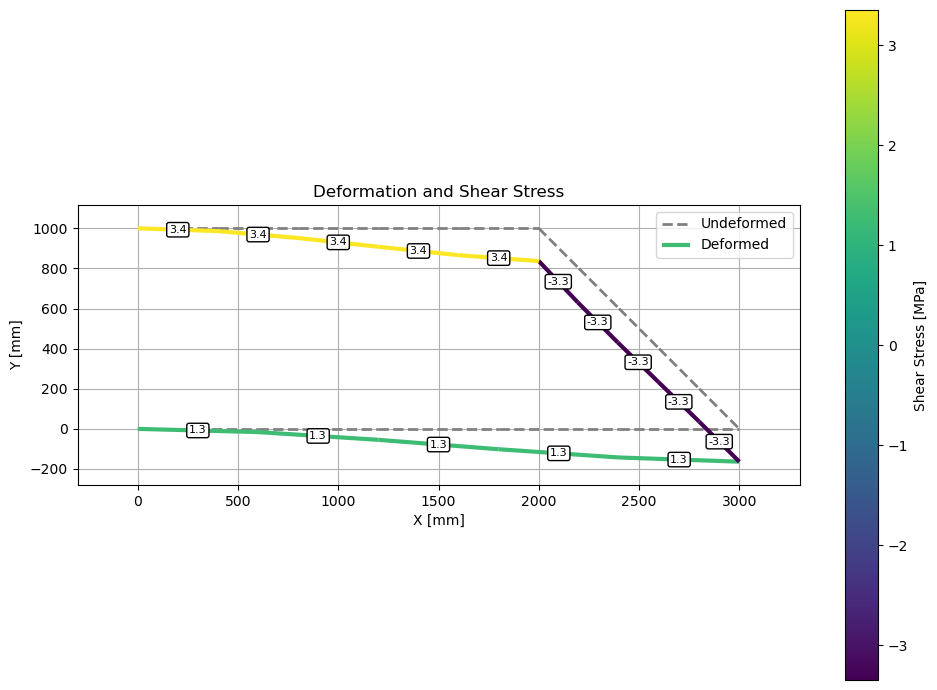

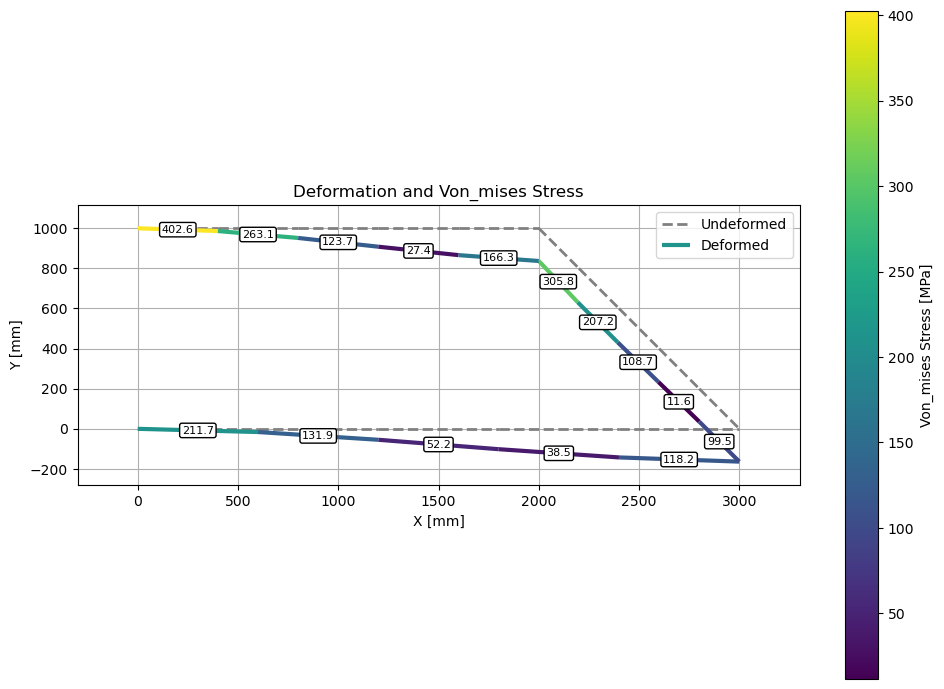

In [12]:
# visualization
stresses = {'max':stress_max,
            'axial':stress_axial,
            'bending':stress_bending,
            'shear':stress_shear,
            'von_Mises': von_mises_stress}

for stress_type in stresses.keys():
    ft.postprocessing.plot_2D_loaded_structure (fem_nodes, fem_elements, u, stresses[stress_type], stress_type=stress_type, ndof_per_node=3, scale=2, show_labels=True)


In [13]:
ft.postprocessing.animate_mode_shape_2D(mode_index=0, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_frame, elements=fem_elements, ndof_per_node=3, amplification=200)